In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/avcrosssell/train.csv
/kaggle/input/avcrosssell/test.csv
/kaggle/input/avcrosssell/sample_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/avcrosssell/train.csv')

print(train_data.shape)

train_data.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
test_data = pd.read_csv('/kaggle/input/avcrosssell/test.csv')

print(test_data.shape)

test_data.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]

#confusing ids

train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns


def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na


def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


Text(0.5, 1.0, 'Response')

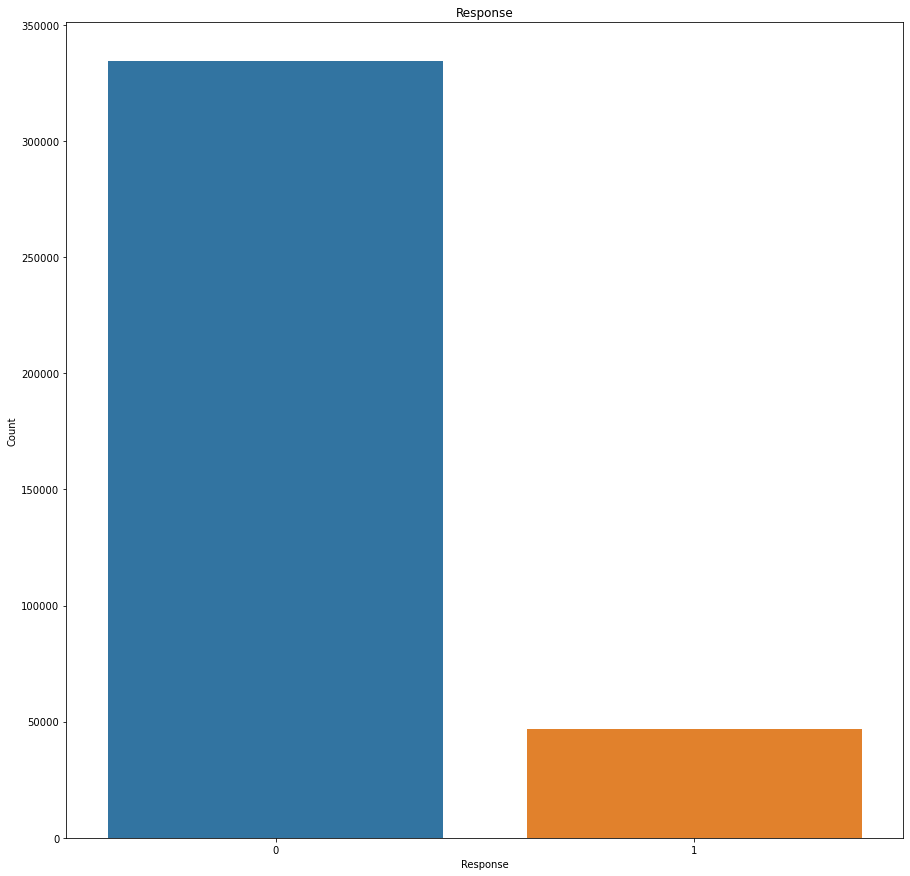

In [7]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [8]:
response

0    334346
1     46657
Name: Count, dtype: int64

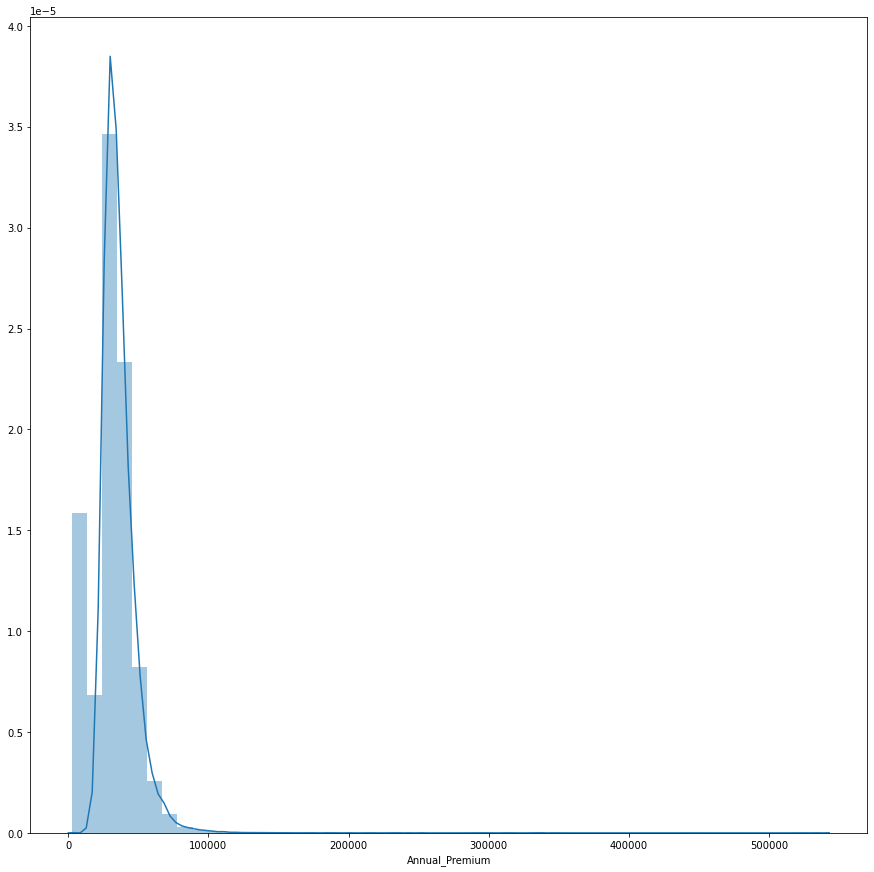

In [9]:
sns.distplot(train_data['Annual_Premium'])

# FE

In [10]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)

In [11]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [12]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [13]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [14]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [15]:
#Used only for XgBoost and LightGBM
test_df.loc[(test_df.Annual_Premium.isin(list(set(test_df.Annual_Premium) - set(train_df.Annual_Premium)))),'Annual_Premium'] = -1

In [16]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [17]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

In [18]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [19]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [20]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [21]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [22]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [23]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,3,1,24158,24,207,...,141873,21323,121,12416,6,0.626550,51.397261,23278.327950,22142.483609,6
1,1,76,1,3,0,2,0,17240,24,173,...,12345,266897,64,9385,10,0.058878,50.517411,11951.893304,10813.151073,10
2,1,47,1,28,0,3,1,21998,24,17,...,141873,21323,121,12416,11,0.626550,51.397261,23278.327950,22142.483609,11
3,1,21,1,11,1,1,0,12323,147,193,...,12328,219792,53,9691,12,0.643929,25.735264,14089.018263,13235.062297,12
4,0,29,1,41,1,1,0,11200,147,29,...,24399,219792,67,10464,11,0.521681,26.792402,16258.510302,15730.565720,11


# LightGBM

In [24]:
trees = 5

n_splits = 5

seeds = [32,432,73,5,2]

submission = pd.read_csv('../input/avcrosssell/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),))

# probablity file per seed per split per tree
submission_probs = pd.DataFrame(columns = ['id','Response'])

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [25]:
%%time

##LightGBM

scores = []

avg_loss = []

submission_name = []

seed_no = []

fold_no = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

for seed in tnrange(len(seeds)):
    
    sssf = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):
        
        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_lgb = [0] *trees

        for i in tnrange(trees):

            print('Tree',i)
            
            seed_no.append(seeds[seed])
            
            fold_no.append(j)
            
            model_lgb[i] = lgb.LGBMClassifier(boosting_type='gbdt',
                                 n_estimators=1000,
                                 max_depth=10,
                                 learning_rate=0.02,
                                 subsample=0.8,
                                 colsample_bytree=0.4,
                                 objective ='binary',
                                 random_state = i*27,
                                 importance_type='gain',
                                 cat_features=cat_features
                                )          
        
            model_lgb[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['binary_logloss','auc'],
                    early_stopping_rounds=50)


            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_lgb_probs = model_lgb[i].predict_proba(test_df)[:,1]
            
            submission_probs.iloc[:,1:] = model_lgb_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            probs += model_lgb_probs
            
            probs_oof = model_lgb[i].predict_proba(X_train_cv.iloc[idxV])[:,1]
            
            roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

            scores.append(roc)

            avg_loss.append(model_lgb[i].best_score_['valid_0']['binary_logloss'])
            
            submission_name.append(probs_file_name)
            
            print ('LGB ROC OOF =',roc)
            
            print('#'*100)
    

print("Average Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))


Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.280044	valid_0's auc: 0.85614
[200]	valid_0's binary_logloss: 0.267812	valid_0's auc: 0.857958
[300]	valid_0's binary_logloss: 0.265086	valid_0's auc: 0.858322
[400]	valid_0's binary_logloss: 0.264385	valid_0's auc: 0.858443
[500]	valid_0's binary_logloss: 0.264183	valid_0's auc: 0.858493
[600]	valid_0's binary_logloss: 0.26413	valid_0's auc: 0.858504
Early stopping, best iteration is:
[563]	valid_0's binary_logloss: 0.264132	valid_0's auc: 0.85852
LGB ROC OOF = 0.8585204844201386
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.282196	valid_0's auc: 0.854823
[200]	valid_0's binary_logloss: 0.268126	valid_0's auc: 0.85788
[300]	valid_0's binary_logloss: 0.265331	valid_0's auc: 0.858303
[400]	valid_0's binary_logloss: 0.264455	valid_0'

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279553	valid_0's auc: 0.857349
[200]	valid_0's binary_logloss: 0.267436	valid_0's auc: 0.858962
[300]	valid_0's binary_logloss: 0.264768	valid_0's auc: 0.859338
[400]	valid_0's binary_logloss: 0.264113	valid_0's auc: 0.859455
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.264057	valid_0's auc: 0.859473
LGB ROC OOF = 0.8594729081430473
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281644	valid_0's auc: 0.856128
[200]	valid_0's binary_logloss: 0.267719	valid_0's auc: 0.85887
[300]	valid_0's binary_logloss: 0.264988	valid_0's auc: 0.859283
[400]	valid_0's binary_logloss: 0.26416	valid_0's auc: 0.859409
[500]	valid_0's binary_logloss: 0.263979	valid_0's auc: 0.859414
Early stopping, best iteration is:
[488]	valid_

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279645	valid_0's auc: 0.857399
[200]	valid_0's binary_logloss: 0.267231	valid_0's auc: 0.859074
[300]	valid_0's binary_logloss: 0.264431	valid_0's auc: 0.859385
[400]	valid_0's binary_logloss: 0.263708	valid_0's auc: 0.859448
Early stopping, best iteration is:
[443]	valid_0's binary_logloss: 0.26356	valid_0's auc: 0.859478
LGB ROC OOF = 0.8594783848308747
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281738	valid_0's auc: 0.856213
[200]	valid_0's binary_logloss: 0.267502	valid_0's auc: 0.859067
[300]	valid_0's binary_logloss: 0.264611	valid_0's auc: 0.85946
[400]	valid_0's binary_logloss: 0.263705	valid_0's auc: 0.859564
Early stopping, best iteration is:
[446]	valid_0's binary_logloss: 0.263556	valid_0's auc: 0.859589
LGB ROC OOF 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279736	valid_0's auc: 0.856431
[200]	valid_0's binary_logloss: 0.267616	valid_0's auc: 0.858063
[300]	valid_0's binary_logloss: 0.265001	valid_0's auc: 0.858389
[400]	valid_0's binary_logloss: 0.264412	valid_0's auc: 0.858463
Early stopping, best iteration is:
[419]	valid_0's binary_logloss: 0.26436	valid_0's auc: 0.858479
LGB ROC OOF = 0.8584790392631522
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.28184	valid_0's auc: 0.85531
[200]	valid_0's binary_logloss: 0.267926	valid_0's auc: 0.857897
[300]	valid_0's binary_logloss: 0.265262	valid_0's auc: 0.858258
[400]	valid_0's binary_logloss: 0.264506	valid_0's auc: 0.858335
[500]	valid_0's binary_logloss: 0.264331	valid_0's auc: 0.858373
[600]	valid_0's binary_logloss: 0.264317	valid_0

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279515	valid_0's auc: 0.857189
[200]	valid_0's binary_logloss: 0.267203	valid_0's auc: 0.858616
[300]	valid_0's binary_logloss: 0.264436	valid_0's auc: 0.858904
[400]	valid_0's binary_logloss: 0.26377	valid_0's auc: 0.858899
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.264018	valid_0's auc: 0.85891
LGB ROC OOF = 0.8589096434423663
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281587	valid_0's auc: 0.856131
[200]	valid_0's binary_logloss: 0.267485	valid_0's auc: 0.858532
[300]	valid_0's binary_logloss: 0.26468	valid_0's auc: 0.858825
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.264107	valid_0's auc: 0.85889
LGB ROC OOF = 0.858890108959562
###############################################

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279139	valid_0's auc: 0.85792
[200]	valid_0's binary_logloss: 0.266799	valid_0's auc: 0.859474
[300]	valid_0's binary_logloss: 0.264059	valid_0's auc: 0.859716
[400]	valid_0's binary_logloss: 0.263371	valid_0's auc: 0.859764
Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.263532	valid_0's auc: 0.85978
LGB ROC OOF = 0.8597798405301483
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281181	valid_0's auc: 0.856979
[200]	valid_0's binary_logloss: 0.267045	valid_0's auc: 0.859468
[300]	valid_0's binary_logloss: 0.264186	valid_0's auc: 0.859852
[400]	valid_0's binary_logloss: 0.263279	valid_0's auc: 0.859937
[500]	valid_0's binary_logloss: 0.263051	valid_0's auc: 0.859972
Early stopping, best iteration is:
[471]	valid_

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279319	valid_0's auc: 0.857564
[200]	valid_0's binary_logloss: 0.267007	valid_0's auc: 0.859206
[300]	valid_0's binary_logloss: 0.264322	valid_0's auc: 0.859536
[400]	valid_0's binary_logloss: 0.263679	valid_0's auc: 0.859611
Early stopping, best iteration is:
[443]	valid_0's binary_logloss: 0.263579	valid_0's auc: 0.859622
LGB ROC OOF = 0.8596224641234259
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281411	valid_0's auc: 0.856355
[200]	valid_0's binary_logloss: 0.267312	valid_0's auc: 0.859017
[300]	valid_0's binary_logloss: 0.264565	valid_0's auc: 0.859372
[400]	valid_0's binary_logloss: 0.263749	valid_0's auc: 0.859484
Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.263703	valid_0's auc: 0.859491
LGB ROC OO

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.28033	valid_0's auc: 0.855007
[200]	valid_0's binary_logloss: 0.268248	valid_0's auc: 0.856874
[300]	valid_0's binary_logloss: 0.265615	valid_0's auc: 0.857295
[400]	valid_0's binary_logloss: 0.264993	valid_0's auc: 0.857405
Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 0.26498	valid_0's auc: 0.857405
LGB ROC OOF = 0.857405217944801
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.282411	valid_0's auc: 0.853743
[200]	valid_0's binary_logloss: 0.268575	valid_0's auc: 0.856763
[300]	valid_0's binary_logloss: 0.265844	valid_0's auc: 0.857247
[400]	valid_0's binary_logloss: 0.26502	valid_0's auc: 0.857409
[500]	valid_0's binary_logloss: 0.264841	valid_0's auc: 0.857443
Early stopping, best iteration is:
[546]	valid_0'

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.280511	valid_0's auc: 0.854998
[200]	valid_0's binary_logloss: 0.268635	valid_0's auc: 0.856631
[300]	valid_0's binary_logloss: 0.266167	valid_0's auc: 0.856942
[400]	valid_0's binary_logloss: 0.265629	valid_0's auc: 0.857052
Early stopping, best iteration is:
[404]	valid_0's binary_logloss: 0.265615	valid_0's auc: 0.857059
LGB ROC OOF = 0.8570586584742006
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.282541	valid_0's auc: 0.854047
[200]	valid_0's binary_logloss: 0.268915	valid_0's auc: 0.856505
[300]	valid_0's binary_logloss: 0.266354	valid_0's auc: 0.856899
[400]	valid_0's binary_logloss: 0.265682	valid_0's auc: 0.856964
Early stopping, best iteration is:
[387]	valid_0's binary_logloss: 0.26573	valid_0's auc: 0.856972
LGB ROC OOF

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279943	valid_0's auc: 0.85642
[200]	valid_0's binary_logloss: 0.267805	valid_0's auc: 0.858002
[300]	valid_0's binary_logloss: 0.26513	valid_0's auc: 0.858337
[400]	valid_0's binary_logloss: 0.264432	valid_0's auc: 0.858452
Early stopping, best iteration is:
[403]	valid_0's binary_logloss: 0.264411	valid_0's auc: 0.858456
LGB ROC OOF = 0.8584557081521907
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281984	valid_0's auc: 0.855344
[200]	valid_0's binary_logloss: 0.268048	valid_0's auc: 0.858039
[300]	valid_0's binary_logloss: 0.265311	valid_0's auc: 0.858401
[400]	valid_0's binary_logloss: 0.26446	valid_0's auc: 0.858508
[500]	valid_0's binary_logloss: 0.264208	valid_0's auc: 0.858557
[600]	valid_0's binary_logloss: 0.264121	valid_0

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279538	valid_0's auc: 0.857331
[200]	valid_0's binary_logloss: 0.267252	valid_0's auc: 0.858934
[300]	valid_0's binary_logloss: 0.264502	valid_0's auc: 0.859221
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.264453	valid_0's auc: 0.859227
LGB ROC OOF = 0.8592274108056713
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281618	valid_0's auc: 0.856306
[200]	valid_0's binary_logloss: 0.267582	valid_0's auc: 0.858835
[300]	valid_0's binary_logloss: 0.264779	valid_0's auc: 0.859123
[400]	valid_0's binary_logloss: 0.263905	valid_0's auc: 0.859176
Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.263936	valid_0's auc: 0.859183
LGB ROC OOF = 0.8591829254218353
##########################################

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279633	valid_0's auc: 0.856794
[200]	valid_0's binary_logloss: 0.267337	valid_0's auc: 0.858619
[300]	valid_0's binary_logloss: 0.264592	valid_0's auc: 0.859057
[400]	valid_0's binary_logloss: 0.26391	valid_0's auc: 0.859186
[500]	valid_0's binary_logloss: 0.263751	valid_0's auc: 0.859192
Early stopping, best iteration is:
[467]	valid_0's binary_logloss: 0.263766	valid_0's auc: 0.859212
LGB ROC OOF = 0.8592124521763221
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.28171	valid_0's auc: 0.855683
[200]	valid_0's binary_logloss: 0.267619	valid_0's auc: 0.8586
[300]	valid_0's binary_logloss: 0.264805	valid_0's auc: 0.859044
[400]	valid_0's binary_logloss: 0.26393	valid_0's auc: 0.85917
[500]	valid_0's binary_logloss: 0.263699	valid_0's 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279934	valid_0's auc: 0.856164
[200]	valid_0's binary_logloss: 0.267761	valid_0's auc: 0.85794
[300]	valid_0's binary_logloss: 0.26515	valid_0's auc: 0.858333
[400]	valid_0's binary_logloss: 0.264556	valid_0's auc: 0.858421
[500]	valid_0's binary_logloss: 0.264434	valid_0's auc: 0.858419
Early stopping, best iteration is:
[472]	valid_0's binary_logloss: 0.264443	valid_0's auc: 0.858443
LGB ROC OOF = 0.858442584001072
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.282017	valid_0's auc: 0.855159
[200]	valid_0's binary_logloss: 0.268069	valid_0's auc: 0.857855
[300]	valid_0's binary_logloss: 0.265343	valid_0's auc: 0.858275
[400]	valid_0's binary_logloss: 0.264564	valid_0's auc: 0.85843
Early stopping, best iteration is:
[426]	valid_0'

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279603	valid_0's auc: 0.857407
[200]	valid_0's binary_logloss: 0.267271	valid_0's auc: 0.859263
[300]	valid_0's binary_logloss: 0.264551	valid_0's auc: 0.859576
[400]	valid_0's binary_logloss: 0.263861	valid_0's auc: 0.859659
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.263764	valid_0's auc: 0.859674
LGB ROC OOF = 0.859673637649706
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281709	valid_0's auc: 0.856134
[200]	valid_0's binary_logloss: 0.26759	valid_0's auc: 0.859101
[300]	valid_0's binary_logloss: 0.264751	valid_0's auc: 0.859504
[400]	valid_0's binary_logloss: 0.263877	valid_0's auc: 0.859602
Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.264074	valid_0's auc: 0.859611
LGB ROC OOF 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279915	valid_0's auc: 0.856456
[200]	valid_0's binary_logloss: 0.267747	valid_0's auc: 0.858372
[300]	valid_0's binary_logloss: 0.265072	valid_0's auc: 0.858865
[400]	valid_0's binary_logloss: 0.264429	valid_0's auc: 0.859008
Early stopping, best iteration is:
[415]	valid_0's binary_logloss: 0.264377	valid_0's auc: 0.859018
LGB ROC OOF = 0.8590176790179147
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281983	valid_0's auc: 0.85533
[200]	valid_0's binary_logloss: 0.268046	valid_0's auc: 0.858266
[300]	valid_0's binary_logloss: 0.265297	valid_0's auc: 0.858783
[400]	valid_0's binary_logloss: 0.264465	valid_0's auc: 0.85897
[500]	valid_0's binary_logloss: 0.26428	valid_0's auc: 0.858977
Early stopping, best iteration is:
[467]	valid_0

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279799	valid_0's auc: 0.856174
[200]	valid_0's binary_logloss: 0.267556	valid_0's auc: 0.857644
[300]	valid_0's binary_logloss: 0.264811	valid_0's auc: 0.857983
[400]	valid_0's binary_logloss: 0.264079	valid_0's auc: 0.858067
Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.26413	valid_0's auc: 0.858074
LGB ROC OOF = 0.8580735336276579
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281903	valid_0's auc: 0.855057
[200]	valid_0's binary_logloss: 0.267862	valid_0's auc: 0.857523
[300]	valid_0's binary_logloss: 0.265036	valid_0's auc: 0.857905
[400]	valid_0's binary_logloss: 0.264138	valid_0's auc: 0.857952
Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.264117	valid_0's auc: 0.857963
LGB ROC OOF

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.280022	valid_0's auc: 0.85607
[200]	valid_0's binary_logloss: 0.267919	valid_0's auc: 0.857674
[300]	valid_0's binary_logloss: 0.265234	valid_0's auc: 0.85807
[400]	valid_0's binary_logloss: 0.264581	valid_0's auc: 0.858162
[500]	valid_0's binary_logloss: 0.264435	valid_0's auc: 0.858171
Early stopping, best iteration is:
[506]	valid_0's binary_logloss: 0.264427	valid_0's auc: 0.858184
LGB ROC OOF = 0.8581836187262214
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.282138	valid_0's auc: 0.854897
[200]	valid_0's binary_logloss: 0.268191	valid_0's auc: 0.857627
[300]	valid_0's binary_logloss: 0.265421	valid_0's auc: 0.858096
[400]	valid_0's binary_logloss: 0.264619	valid_0's auc: 0.858159
Early stopping, best iteration is:
[438]	valid_

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279488	valid_0's auc: 0.85703
[200]	valid_0's binary_logloss: 0.267227	valid_0's auc: 0.858536
[300]	valid_0's binary_logloss: 0.264527	valid_0's auc: 0.858811
Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.264686	valid_0's auc: 0.858815
LGB ROC OOF = 0.8588153821450388
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281574	valid_0's auc: 0.85599
[200]	valid_0's binary_logloss: 0.267484	valid_0's auc: 0.858557
[300]	valid_0's binary_logloss: 0.264715	valid_0's auc: 0.858874
[400]	valid_0's binary_logloss: 0.263877	valid_0's auc: 0.858906
Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.26392	valid_0's auc: 0.858915
LGB ROC OOF = 0.85891472356336
###############################################

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279356	valid_0's auc: 0.857516
[200]	valid_0's binary_logloss: 0.26715	valid_0's auc: 0.859034
[300]	valid_0's binary_logloss: 0.264428	valid_0's auc: 0.859335
[400]	valid_0's binary_logloss: 0.263709	valid_0's auc: 0.859453
[500]	valid_0's binary_logloss: 0.263496	valid_0's auc: 0.85948
Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.263558	valid_0's auc: 0.859497
LGB ROC OOF = 0.8594970637706629
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281473	valid_0's auc: 0.856289
[200]	valid_0's binary_logloss: 0.267498	valid_0's auc: 0.858889
[300]	valid_0's binary_logloss: 0.2647	valid_0's auc: 0.859229
[400]	valid_0's binary_logloss: 0.263807	valid_0's auc: 0.859333
[500]	valid_0's binary_logloss: 0.263558	valid_0'

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279802	valid_0's auc: 0.8567
[200]	valid_0's binary_logloss: 0.267537	valid_0's auc: 0.858474
[300]	valid_0's binary_logloss: 0.264817	valid_0's auc: 0.858855
[400]	valid_0's binary_logloss: 0.264168	valid_0's auc: 0.85894
Early stopping, best iteration is:
[399]	valid_0's binary_logloss: 0.264173	valid_0's auc: 0.858941
LGB ROC OOF = 0.8589408998273774
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281887	valid_0's auc: 0.855617
[200]	valid_0's binary_logloss: 0.267851	valid_0's auc: 0.858281
[300]	valid_0's binary_logloss: 0.265069	valid_0's auc: 0.858683
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.264521	valid_0's auc: 0.85876
LGB ROC OOF = 0.8587596010256919
##############################################

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279861	valid_0's auc: 0.856163
[200]	valid_0's binary_logloss: 0.267676	valid_0's auc: 0.857758
[300]	valid_0's binary_logloss: 0.264957	valid_0's auc: 0.858078
[400]	valid_0's binary_logloss: 0.26428	valid_0's auc: 0.858214
Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.26417	valid_0's auc: 0.858235
LGB ROC OOF = 0.85823491493145
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281915	valid_0's auc: 0.855152
[200]	valid_0's binary_logloss: 0.267901	valid_0's auc: 0.857771
[300]	valid_0's binary_logloss: 0.265098	valid_0's auc: 0.858209
[400]	valid_0's binary_logloss: 0.264258	valid_0's auc: 0.858316
Early stopping, best iteration is:
[427]	valid_0's binary_logloss: 0.264155	valid_0's auc: 0.858341
LGB ROC OOF = 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279664	valid_0's auc: 0.856974
[200]	valid_0's binary_logloss: 0.267403	valid_0's auc: 0.858472
[300]	valid_0's binary_logloss: 0.264659	valid_0's auc: 0.85887
[400]	valid_0's binary_logloss: 0.263983	valid_0's auc: 0.858947
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.26418	valid_0's auc: 0.85896
LGB ROC OOF = 0.858959513861443
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281701	valid_0's auc: 0.855859
[200]	valid_0's binary_logloss: 0.267644	valid_0's auc: 0.858538
[300]	valid_0's binary_logloss: 0.26485	valid_0's auc: 0.858914
[400]	valid_0's binary_logloss: 0.264018	valid_0's auc: 0.85901
[500]	valid_0's binary_logloss: 0.263831	valid_0's auc: 0.859024
Early stopping, best iteration is:
[467]	valid_0's 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279884	valid_0's auc: 0.855711
[200]	valid_0's binary_logloss: 0.267872	valid_0's auc: 0.857339
[300]	valid_0's binary_logloss: 0.265283	valid_0's auc: 0.857698
[400]	valid_0's binary_logloss: 0.264675	valid_0's auc: 0.857798
Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.26464	valid_0's auc: 0.857801
LGB ROC OOF = 0.8578006004272924
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281895	valid_0's auc: 0.854777
[200]	valid_0's binary_logloss: 0.268157	valid_0's auc: 0.857338
[300]	valid_0's binary_logloss: 0.265484	valid_0's auc: 0.857722
[400]	valid_0's binary_logloss: 0.264708	valid_0's auc: 0.857836
Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.264743	valid_0's auc: 0.857841
LGB ROC OOF

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279763	valid_0's auc: 0.856657
[200]	valid_0's binary_logloss: 0.267539	valid_0's auc: 0.858265
[300]	valid_0's binary_logloss: 0.264868	valid_0's auc: 0.858536
[400]	valid_0's binary_logloss: 0.264252	valid_0's auc: 0.85856
Early stopping, best iteration is:
[418]	valid_0's binary_logloss: 0.264186	valid_0's auc: 0.858595
LGB ROC OOF = 0.8585951284976967
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281857	valid_0's auc: 0.855575
[200]	valid_0's binary_logloss: 0.267873	valid_0's auc: 0.85813
[300]	valid_0's binary_logloss: 0.265161	valid_0's auc: 0.858406
[400]	valid_0's binary_logloss: 0.264339	valid_0's auc: 0.858483
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.264352	valid_0's auc: 0.858488
LGB ROC OOF 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.279871	valid_0's auc: 0.856805
[200]	valid_0's binary_logloss: 0.267617	valid_0's auc: 0.858698
[300]	valid_0's binary_logloss: 0.264928	valid_0's auc: 0.859113
[400]	valid_0's binary_logloss: 0.264293	valid_0's auc: 0.859184
Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.264261	valid_0's auc: 0.859187
LGB ROC OOF = 0.8591868875239228
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.281964	valid_0's auc: 0.855605
[200]	valid_0's binary_logloss: 0.267921	valid_0's auc: 0.858586
[300]	valid_0's binary_logloss: 0.265142	valid_0's auc: 0.859041
[400]	valid_0's binary_logloss: 0.264322	valid_0's auc: 0.859156
[500]	valid_0's binary_logloss: 0.264114	valid_0's auc: 0.859187
Early stopping, best iteration is:
[489]	vali

In [26]:
submission_probs.iloc[:,1:] = probs/(len(seeds)*trees*n_splits)

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [27]:
model_stats = pd.DataFrame({'submission':submission_name,'seed': seed_no,'fold':fold_no,'oof_roc':scores,'validation_loss':avg_loss})

model_stats.to_csv('model_stats.csv',index =False)

model_stats.head()

,submission,seed,fold,oof_roc,validation_loss
0,probs_32_0_0.csv,32,0,0.858520,0.264132
1,probs_32_0_1.csv,32,0,0.858574,0.264060
2,probs_32_0_2.csv,32,0,0.858536,0.264174
3,probs_32_0_3.csv,32,0,0.858607,0.264174
4,probs_32_0_4.csv,32,0,0.858607,0.264075
